# Lecture 3 (Options Markets) Assignment

## Chenyu Zhao

### Question 1 (4 marks)

Derive the expression for the ATM strike, given the ATM volatility and other market parameters, in the case where the market convention premium currency is the asset currency. In that case the price of the portfolio is



where  is the price of the portfolio (which varies with spot S),  is the price of the option (which varies with spot S), S is the spot,  is the initial spot (at the time of the trade), and  is the initial price of the option (equal to ). Note that the option here might be a call or might be a put.

Calculate the derivative of  with respect to S to get the delta of the portfolio (taking at spot S=), and then solve for the strike that makes the delta of a call portfolio equal to the negative of the delta of a put portfolio (using Black-Scholes formulas for the call and put prices and deltas).

#### Answer

Delta of the portfolio is 

$$
\Delta_{\pi}(S) = \Delta(S) - \frac{\nu_0}{S_0}
$$

When $S=S_0$

$$
\Delta_{\pi}(S_0) = \Delta(S_0) - \frac{\nu_0}{S_0}
$$

When deltas of call option and put option are equal,

$$
\Delta_{call} = e^{-QT}N(d_1) = \Delta_{put} = e^{-QT}N(-d_1)
$$

So we have $d_1 = 0$, which means

$$
ln(\frac{S}{K}) + (R-Q+\frac{\sigma^2}{2})T=0
$$

because $F = Se^{(R-Q)T}$, therefore

$$
K = Fe^{\frac{\sigma^2T}{2}}
$$

### Question 2 (4 marks)

Assume an FX market where the spot is 1, time to expiration is 0.5y, forward points are +0.0040, and the denominated discount rate is 1.75%. What is the strike corresponding to a 25-delta call option when its implied volatility is 8.75%, using market-convention delta? Assume the market convention premium currency is the denominated currency.

#### Answer

$$
K_c = Fe^{\frac{\sigma_k^2}{2}T-\sigma_k\sqrt{T}N^{-1}(\Delta_c e^{qT})}
$$

where $F =\text{spot}+\text{forward point} = 1.0040$, $\sigma_k$ is the implied volatility $8.75\%$, $\Delta_c = 0.25$

We also have $F = S_0e^{(r-q)T}$, and we know $F$ and $r=1.75\%$, thus we can solve $q=0.952\%$

Finally we have $K_c=1.0485$

### Question 3 (2 marks)

Describe the risk reversal “beta”.

#### Answer

Moves in risk reversals have a relatively high correlation with moves in spot. This is often quantified as the “risk reversal beta”, or the slope of a linear regression of day-on-day risk reversal change against spot log return. A number like 0.2 means “risk reversal gets more positive by 0.2 vols for every 1% move up in spot”.

You can run a regression to get the estimated beta as slope. The risk reversal beta is a curve, has value for every specific tenor.

### Question 4 (2 marks)

Explain the two arbitrage conditions that should be avoided when interpolating in the strike direction, and the one (weak) arbitrage condition to avoid when interpolating in the time direction.


#### Answer 

two arbitrage conditions that should be avoided:
1. $\frac{dC}{dK}>0$

2. $\frac{d^2C}{dK^2}<0$

one (weak) arbitrage condition to avoid when interpolating in the time direction:

1. $\sigma_i^2(T)T$ should always increase, where $\sigma_i$ is implied volatility

### Question 5 (10 marks)

Implement a cubic spline interpolation for implied volatility vs strike which has non-standard boundary conditions to give more intuitive volatility extrapolation.

Assume you are given five implied volatilities,  through , for five known strikes,  through , for some known time to expiration .

Set up the boundary condition of the cubic spline such that implied volatility reaches a constant value a certain distance beyond the edge points. The distance is defined by a parameter, the cubic spline extrapolation parameter, F. On the left side, for strikes less than the minimum marked strike , implied volatility reaches a constant value at strike :



and on the right side, for strikes greater that the maximum marked strike , implied volatility reaches a constant value at strike :



Start with the standard method for defining a cubic spline (eg here: http://www.aip.de/groups/soe/local/numres/bookcpdf/c3-3.pdf), but add in two extra points at  and  where you know that the slope of vol vs strike goes to zero, and the second derivative of vol vs strike goes to zero, but where you do not know the value of volatility (that comes out of the solution for the cubic spline). Of course the first and second derivatives of vol vs strike should be continuous across  and .

Implement a Python class that is initialized with the five strikes, five implied volatilities, time to expiration, and cubic spline extrapolation parameter. As part of initialization it will need to solve a linear system to generate the cubic spline parameters, for which you can use the functions in the scipy or numpy packages. The class should include a “volatility” method that takes a strike and returns an interpolated volatility.

Finally, generate plots of implied volatility vs strike for F=0.01 and F=10 for the following market: T=0.5y; ATM volatility of 8%, 25-delta risk reversal of 1%, 10-delta risk reversal of 1.8%, 25-delta butterfly of 0.25%, and 10-delta butterfly of 0.80%; spot=1; forward points=0; denominated discount rate=0%. You should return one chart with the two curves on it, showing implied volatility vs strike for all strikes between the 1-delta put and 1-delta call. 

Give some intuition behind the shape of the two plots in terms of the value of F.

#### Answer

In [11]:
import bisect
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

In [21]:
class CubicSpline:  
    def __init__(self, Ks, vols, T, F):
        
        K_min = Ks[0]  * np.exp(-F * vols[0]  * np.sqrt(T))
        K_max = Ks[-1] * np.exp( F * vols[-1] * np.sqrt(T))
        self.Ks = [K_min] + Ks + [K_max]
        
        M = np.array([[0.0 for i in range(24)] for j in range(24)])
        
        for i in range(5):
            M[4*i+2][4*i] = 1
            M[4*i+2][4*i+1] = self.Ks[i+1]
            M[4*i+2][4*i+2] = self.Ks[i+1]**2
            M[4*i+2][4*i+3] = self.Ks[i+1]**3
            
            M[4*i+3][4*i] = 1
            M[4*i+3][4*i+1] = self.Ks[i+1]
            M[4*i+3][4*i+2] = self.Ks[i+1]**2
            M[4*i+3][4*i+3] = self.Ks[i+1]**3
            M[4*i+3][4*i+4] = -1
            M[4*i+3][4*i+5] = -self.Ks[i+1]
            M[4*i+3][4*i+6] = -self.Ks[i+1]**2
            M[4*i+3][4*i+7] = -self.Ks[i+1]**3
            
            M[4*i+4][4*i+1] = 1
            M[4*i+4][4*i+2] = 2*self.Ks[i+1]
            M[4*i+4][4*i+3] = 3*self.Ks[i+1]**2
            M[4*i+4][4*i+5] = -1
            M[4*i+4][4*i+6] = -2*self.Ks[i+1]
            M[4*i+4][4*i+7] = -3*self.Ks[i+1]**2
            
            M[4*i+5][4*i+2] = 2
            M[4*i+5][4*i+3] = 6*self.Ks[i+1]
            M[4*i+5][4*i+6] = -2
            M[4*i+5][4*i+7] = -6*self.Ks[i+1]
        
        
        # left boundary
        M[0][1] = 1
        M[0][2] = 2*K_min
        M[0][3] = 3*K_min*K_min
        M[1][2] = 2
        M[1][3] = 6*K_min
        
        # right boundary
        M[24-2][24-3] = 1
        M[24-2][24-2] = 2*K_max
        M[24-2][24-1] = 3*K_max*K_max
        M[24-1][24-2] = 2
        M[24-1][24-1] = 6*K_max
        
        # y, where Mx=y  
        y = np.zeros(24)
        for i in range(5): # i=0,...,4
            y[4*i+2] = vols[i]
        
        # solve linear system
        x = np.linalg.solve(M,y)
        
        # different orders' coefficients
        self.x1 = [ x[4*i] for i in range(6) ]
        self.x2 = [ x[4*i+1] for i in range(6) ]
        self.x3 = [ x[4*i+2] for i in range(6) ]
        self.x4 = [ x[4*i+3] for i in range(6) ]
        
        
    def impvol(self, K):
        
        # if out of boundary
        if K < self.Ks[0]:
            K = self.Ks[0]
        elif K > self.Ks[-1]:
            K = self.Ks[-1]
            
        index = bisect.bisect_left(self.Ks, K)-1 
        if index < 0:
            index = 0
        elif index > 5:
            index = 5
            
        x1 = self.x1[index]
        x2 = self.x2[index]
        x3 = self.x3[index]
        x4 = self.x4[index]
        
        return x1 + x2*K + x3*K**2 + x4*K**3

In [22]:
F1 = 0.01
F2 = 10
T = 0.5
spot = 1

atm = 0.08
reversal25 = 0.01
reversal10 = 0.018
butterfly25 = 0.0025
butterfly10 = 0.0080

# solve vol 
vol25c = atm + reversal25 / 2 + butterfly25
vol25p = atm - reversal25 / 2 + butterfly25
vol10c = atm + reversal10 / 2 + butterfly10
vol10p = atm - reversal10 / 2 + butterfly10

# solve strike
atmK = spot * np.exp(atm**2 * T /2.)
K25c  = spot * np.exp(vol25c**2  * T / 2. - vol25c * np.sqrt(T) * norm.ppf(0.25))
K25p  = spot * np.exp(vol25p**2  * T / 2. + vol25p * np.sqrt(T) * norm.ppf(0.25))
K10c  = spot * np.exp(vol10c**2  * T / 2. - vol10c * np.sqrt(T) * norm.ppf(0.10))
K10p  = spot * np.exp(vol10p**2  * T / 2. + vol10p * np.sqrt(T) * norm.ppf(0.10))

Ks = [K10p, K25p, atmK, K25c, K10c]
vols = [vol10p, vol25p, atm, vol25c, vol10c]

# create cubic spline classes
CS1 = CubicSpline(Ks, vols, T, F1)
CS2 = CubicSpline(Ks, vols, T, F2)

In [28]:
# set grid to plot
c = spot * np.exp(vol10p ** 2 * T / 2. + vol10p * np.sqrt(T) * norm.ppf(0.01))
K_max = spot * np.exp(vol10c ** 2 * T / 2. - vol10c * np.sqrt(T) * norm.ppf(0.01))

# plot 1000 points for strike
n = 1000
dK = (K_max - K_min ) / (n - 1)
K_list,vol1_list,vol2_list = [], [], []

for i in range(n):
    K = K_min + i * dK
    K_list.append(K_min + i * dK)
    vol1_list.append(CS1.impvol(K) * 100)
    vol2_list.append(CS2.impvol(K) * 100)

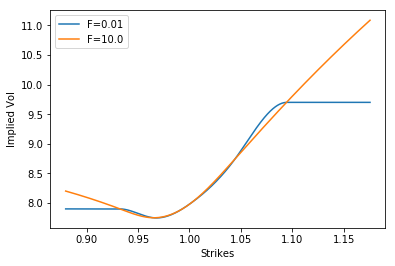

In [29]:
line1, = plt.plot(K_list, vol1_list, label='F=0.01')
line2, = plt.plot(K_list, vol2_list, label='F=10.0')
plt.xlabel('Strikes')
plt.ylabel('Implied Vol')
plt.legend()
plt.show()

F represents the preset vol outside of the boundary. We can see for $F=0.01$, it flats very quickly. For $F=10$, it goes linearly because 10 is far away from the market point.